In [30]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"

import keras
from keras import layers
import matplotlib.pyplot as plt

import gc
from IPython.display import clear_output
from typing import Optional, Tuple, List, Union, Any
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import chain
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import concatenate, add
from keras.layers import Lambda, RepeatVector, Reshape, Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout


import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [31]:
import os
import numpy as np
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Cargar los DataFrames desde los archivos CSV
csv_path_1 = '/data/Datasets/Nodules_ISBI/meta_created_info_3d_3R.csv'
csv_path_2 = '/data/Datasets/Nodules_ISBI/meta_created_info_3d_4R.csv'
data_df_1 = pd.read_csv(csv_path_1)
data_df_2 = pd.read_csv(csv_path_2)

# Concatenar los DataFrames
combined_df = pd.concat([data_df_1, data_df_2], ignore_index=True)

# Filtrar para incluir solo 'True' y 'False'
filtered_df = combined_df[combined_df['is_cancer'].isin(['True', 'False'])]

# Mapear 'True' a 1 y 'False' a 0
filtered_df['is_cancer'] = filtered_df['is_cancer'].map({'True': 1, 'False': 0})

# Extraer descriptores de forma del CSV y normalizarlos
shape_descriptors_csv = filtered_df[['lobulation', 'texture', 'spiculation', 'margin']].values
scaler_csv = StandardScaler()
normalized_shape_descriptors_csv = scaler_csv.fit_transform(shape_descriptors_csv)

# Crear un diccionario para mapear carpetas a etiquetas
image_labels = dict(zip(filtered_df['folder'], filtered_df['is_cancer']))

# Definir las rutas de las carpetas
patch_folder_path = '/data/Datasets/Nodules_ISBI/images'
mask_folder_path = '/data/Datasets/Nodules_ISBI/masks'

# Función para cargar el archivo .npy del medio en la carpeta especificada
def load_middle_npy_file(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    files.sort()
    middle_index = len(files) // 2
    return np.load(os.path.join(folder_path, files[middle_index])) if files else None

# Listas para almacenar muestras y su información correspondiente
patch_samples = []
mask_samples = []
labels = []
csv_descriptors = []

# Procesar las carpetas comunes entre parches y máscaras
patch_folders = set(os.listdir(patch_folder_path))
mask_folders = set(os.listdir(mask_folder_path))
common_folders = patch_folders & mask_folders
common_folders = [folder for folder in common_folders if folder in image_labels]

for folder_name in common_folders:
    patch = load_middle_npy_file(os.path.join(patch_folder_path, folder_name))
    mask = load_middle_npy_file(os.path.join(mask_folder_path, folder_name))

    if patch is not None and mask is not None:
        # Redimensionar a 32x32
        resized_patch = resize(patch, (32, 32), anti_aliasing=True)
        resized_mask = resize(mask, (32, 32), anti_aliasing=False)

        patch_samples.append(resized_patch)
        mask_samples.append(resized_mask)
        labels.append(image_labels[folder_name])
        csv_descriptors.append(normalized_shape_descriptors_csv[filtered_df['folder'].tolist().index(folder_name)])

# Convertir las listas en arrays de numpy
patch_samples = np.stack(patch_samples)
mask_samples = np.stack(mask_samples)
labels = np.array(labels)
csv_descriptors = np.array(csv_descriptors)

# Normalizar los descriptores combinados
scaler_combined = StandardScaler()
csv_descriptors = scaler_combined.fit_transform(csv_descriptors)

# Verificar la forma de los datos
print(f"Tamaño de los samples de parches: {patch_samples.shape}")
print(f"Tamaño de los samples de máscaras: {mask_samples.shape}")
print(f"Tamaño de los labels: {labels.shape}")
print(f"Tamaño de los descriptores CSV: {csv_descriptors.shape}")


/tmp/ipykernel_797021/3307775372.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['is_cancer'] = filtered_df['is_cancer'].map({'True': 1, 'False': 0})


Tamaño de los samples de parches: (533, 32, 32)
Tamaño de los samples de máscaras: (533, 32, 32)
Tamaño de los labels: (533,)
Tamaño de los descriptores CSV: (533, 4)


In [32]:
import os
import numpy as np
from skimage.transform import rotate, resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Directorios base
base_dir = 'Laura_files/data'
subdirs = {
    'train_mask': os.path.join(base_dir, 'train_data', 'masks'),
    'test_mask': os.path.join(base_dir, 'test_data', 'masks'),
    'val_mask': os.path.join(base_dir, 'val_data', 'masks'),
    'train_patch': os.path.join(base_dir, 'train_data', 'patches'),
    'test_patch': os.path.join(base_dir, 'test_data', 'patches'),
    'val_patch': os.path.join(base_dir, 'val_data', 'patches')
}

# Asegurarse que los directorios existan
for subdir in subdirs.values():
    os.makedirs(subdir, exist_ok=True)

# Partición inicial de los datos (sin aumento todavía)
train_patches, test_patches, train_masks, test_masks, train_labels, test_labels, train_csv_descriptors, test_csv_descriptors = train_test_split(
    patch_samples, mask_samples, labels, csv_descriptors, test_size=0.2, random_state=42)

train_patches, val_patches, train_masks, val_masks, train_labels, val_labels, train_csv_descriptors, val_csv_descriptors = train_test_split(
    train_patches, train_masks, train_labels, train_csv_descriptors, test_size=0.2, random_state=42)

# Aumento de datos por rotaciones solo para el conjunto de entrenamiento
rotation_angles = [90, 180, 270]  # Ángulos de rotación en grados

def augment_data(patches, masks, csv_descriptors, labels, angles=rotation_angles):
    augmented_patches = []
    augmented_masks = []
    augmented_csv_descriptors = []
    augmented_labels = []

    # Aplicar rotaciones a cada parche y máscara
    for i in range(len(patches)):
        patch = patches[i]
        mask = masks[i]
        label = labels[i]
        csv_descriptor = csv_descriptors[i]  # El descriptor CSV no cambia con las rotaciones

        # Añadir la imagen original
        augmented_patches.append(patch)
        augmented_masks.append(mask)
        augmented_labels.append(label)
        augmented_csv_descriptors.append(csv_descriptor)

        # Aplicar rotaciones
        for angle in angles:
            rotated_patch = rotate(patch, angle, resize=False)
            rotated_mask = rotate(mask, angle, resize=False)

            augmented_patches.append(rotated_patch)
            augmented_masks.append(rotated_mask)
            augmented_labels.append(label)
            augmented_csv_descriptors.append(csv_descriptor)  # El CSV sigue siendo el mismo

    return np.array(augmented_patches), np.array(augmented_masks), np.array(augmented_csv_descriptors), np.array(augmented_labels)

# Aumentar los datos aplicando rotaciones solo a los parches y máscaras del conjunto de entrenamiento
augmented_train_patches, augmented_train_masks, augmented_train_csv_descriptors, augmented_train_labels = augment_data(
    train_patches, train_masks, train_csv_descriptors, train_labels)

# Función para guardar datos en archivos npy
def save_data(data, dir_path, prefix):
    for i, sample in enumerate(data):
        np.save(os.path.join(dir_path, f'{prefix}_{i}.npy'), sample)

# Guardar los datos de en/content/drive/MyDrive/trenamiento (aumentados)
save_data(augmented_train_masks, subdirs['train_mask'], 'mask')
save_data(augmented_train_patches, subdirs['train_patch'], 'patch')

# Guardar los datos de prueba (sin aumento)
save_data(test_masks, subdirs['test_mask'], 'mask')
save_data(test_patches, subdirs['test_patch'], 'patch')

# Guardar los datos de validación (sin aumento)
save_data(val_masks, subdirs['val_mask'], 'mask')
save_data(val_patches, subdirs['val_patch'], 'patch')

print(f"Train samples after augmentation: {len(augmented_train_patches)}")
print(f"Validation samples: {len(val_patches)}, Test samples: {len(test_patches)}")


Train samples after augmentation: 1360
Validation samples: 86, Test samples: 107


In [33]:
# Verificar las formas de los datos y descriptores
print(f"Tamaño de los descriptores de entrenamiento: {augmented_train_csv_descriptors.shape}")
print(f"Tamaño de los descriptores de validación: {val_csv_descriptors.shape}")
print(f"Tamaño de los descriptores de prueba: {test_csv_descriptors.shape}")


Tamaño de los descriptores de entrenamiento: (1360, 4)
Tamaño de los descriptores de validación: (86, 4)
Tamaño de los descriptores de prueba: (107, 4)


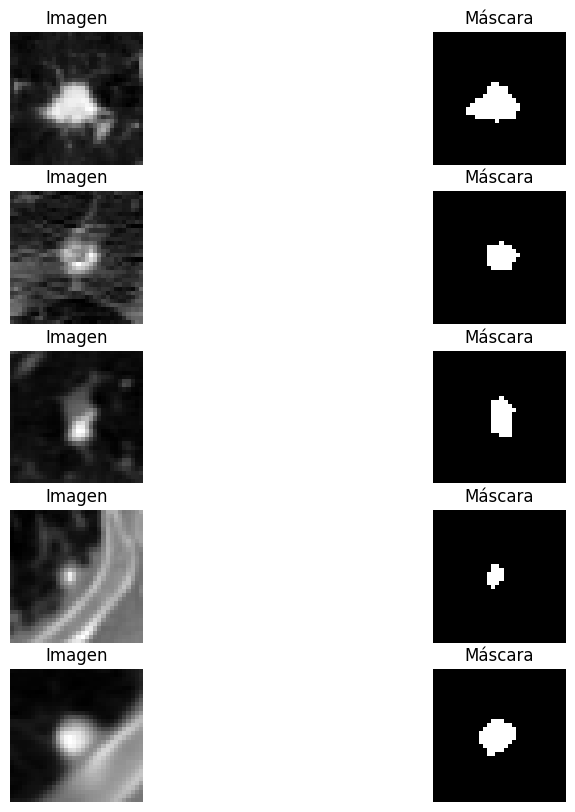

In [34]:
def visualize_samples(patches, masks, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(patches[i].squeeze(), cmap='gray')
        plt.title('Imagen')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Máscara')
        plt.axis('off')
    plt.show()

visualize_samples(train_patches, train_masks)


In [35]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization, Dense, Reshape, Activation
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier


In [36]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               kernel_initializer='he_normal', padding='same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Definir la U-Net con dos entradas (imágenes y CSV), combinando embebido para el decoder
def get_unet_with_csv_input(input_img, input_csv, n_filters=16, dropout=0.1, batchnorm=True):
    # Bloque U-Net (entrada de imagen)
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm)

    # Crear el embebido de los descriptores CSV y darle forma para que se pueda concatenar
    csv_embedding = Dense(n_filters * 16, activation='relu')(input_csv)
    csv_embedding = Dropout(dropout)(csv_embedding)
    csv_embedding = Dense(c5.shape[1] * c5.shape[2] * c5.shape[3], activation='relu')(csv_embedding)
    csv_embedding = Reshape((c5.shape[1], c5.shape[2], c5.shape[3]))(csv_embedding)

    # Concatenar el embebido del CSV con la salida del encoder (c5)
    combined_embedding = concatenate([c5, csv_embedding])

    # Decodificación de la U-Net después de la concatenación
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(combined_embedding)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size=3, batchnorm=batchnorm)

    # Salida de la segmentación
    segmentation_output = Conv2D(1, (1, 1), activation='sigmoid', name='segmentation_output')(c9)

    return Model(inputs=[input_img, input_csv], outputs=segmentation_output), combined_embedding

In [37]:
# Definir las entradas
input_img = Input((32, 32, 1), name='img')
input_csv = Input((train_csv_descriptors.shape[1],), name='csv_data')

# Crear el modelo U-Net con las dos entradas
model_unet_with_csv, combined_embedding = get_unet_with_csv_input(input_img, input_csv, n_filters=16, dropout=0.1, batchnorm=True)

model_unet_with_csv.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img (InputLayer)            [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_72 (Conv2D)          (None, 32, 32, 16)           160       ['img[0][0]']                 
                                                                                                  
 batch_normalization_72 (Ba  (None, 32, 32, 16)           64        ['conv2d_72[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_72 (Activation)  (None, 32, 32, 16)           0         ['batch_normalization_72

In [38]:
# Definir las entradas
input_img = Input((32, 32, 1), name='img')
input_csv = Input((train_csv_descriptors.shape[1],), name='csv_data')

# Crear el modelo U-Net con las dos entradas
model_unet_with_csv, combined_embedding = get_unet_with_csv_input(input_img, input_csv, n_filters=16, dropout=0.1, batchnorm=True)

# Compilar el modelo (solo para segmentación)
model_unet_with_csv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo solo para segmentación
history = model_unet_with_csv.fit(
    [train_patches, train_csv_descriptors],  # Imágenes y CSV como entrada
    train_masks,  # Solo máscaras para segmentación
    epochs=50,
    batch_size=32,
    validation_data=([val_patches, val_csv_descriptors], val_masks),
    callbacks=[
        ModelCheckpoint('best_model_with_csv.h5', save_best_only=True, monitor='val_loss', mode='min'),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)

Epoch 1/50


2024-09-20 19:42:35.997764: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_45/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


11/11 [==============================] - 8s 77ms/step - loss: 0.6692 - accuracy: 0.6168 - val_loss: 0.6528 - val_accuracy: 0.9446
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 0s 24ms/step - loss: 0.4611 - accuracy: 0.8567 - val_loss: 1.2925 - val_accuracy: 0.5386
Epoch 3/50
11/11 [==============================] - 0s 20ms/step - loss: 0.3589 - accuracy: 0.9331 - val_loss: 1.3447 - val_accuracy: 0.7035
Epoch 4/50
11/11 [==============================] - 0s 23ms/step - loss: 0.2990 - accuracy: 0.9666 - val_loss: 1.2260 - val_accuracy: 0.7318
Epoch 5/50
11/11 [==============================] - 0s 24ms/step - loss: 0.2592 - accuracy: 0.9769 - val_loss: 0.9260 - val_accuracy: 0.7847
Epoch 6/50
11/11 [==============================] - 0s 25ms/step - loss: 0.2338 - accuracy: 0.9793 - val_loss: 0.7164 - val_accuracy: 0.8871
Epoch 7/50
11/11 [==============================] - 0s 41ms/step - loss: 0.2140 - accuracy: 0.9801 - val_loss: 0.4657 - val_accuracy: 0.9432
Epoch 8/50
11/11 [==============================] - 0s 25ms/step - loss: 0.1962 - accuracy: 0.9824 - val_loss: 0.5353 - val_accuracy: 0.9214
Epoch 9/50
11/11 [======

In [39]:
# Visualización de predicciones de segmentación con umbral
import matplotlib.pyplot as plt

def plot_sample_images(patches, masks, predictions, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i+1)
        plt.imshow(patches[i].squeeze(), cmap='gray')
        plt.title('Imagen')
        plt.axis('off')

        plt.subplot(3, num_samples, i+1+num_samples)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Máscara')
        plt.axis('off')


        plt.subplot(3, num_samples, i+1+2*num_samples)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Predicción')
        plt.axis('off')

    plt.show()

3/3 [==============================] - 0s 5ms/step


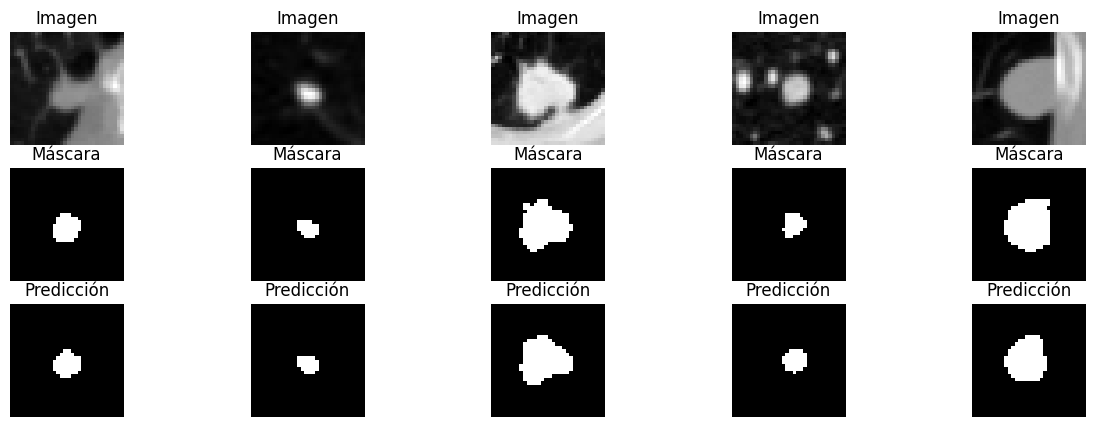

In [40]:
# Obtener las predicciones de segmentación con los datos de validación
predictions = model_unet_with_csv.predict([val_patches, val_csv_descriptors])

# Aplicar el umbral para obtener máscaras binarias
predictions = (predictions > 0.3).astype('float32')

# Visualizar algunas predicciones
plot_sample_images(val_patches, val_masks, predictions)


In [41]:
# Crear un modelo separado para obtener el embebido combinado (c5 + descriptores CSV)
model_combined_embedding = Model(inputs=[input_img, input_csv], outputs=combined_embedding)

# Obtener embebido combinado después del entrenamiento
combined_embedding_output = model_combined_embedding.predict([train_patches, train_csv_descriptors])


11/11 [==============================] - 0s 2ms/step


In [42]:

combined_embedding_flat = combined_embedding_output.reshape(combined_embedding_output.shape[0], -1)


In [49]:
# Importar las bibliotecas necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model

# Crear un modelo separado para obtener el embebido combinado (c5 + descriptores CSV)
model_combined_embedding = Model(inputs=[input_img, input_csv], outputs=combined_embedding)

# Obtener embebido combinado después del entrenamiento (para el conjunto de entrenamiento)
combined_embedding_output = model_combined_embedding.predict([train_patches, train_csv_descriptors])

# Obtener embebido combinado para el conjunto de test
test_combined_embedding_output = model_combined_embedding.predict([test_patches, test_csv_descriptors])

# Aplanar el embebido combinado del conjunto de entrenamiento
train_combined_embedding_flat = combined_embedding_output.reshape(combined_embedding_output.shape[0], -1)

# Crear el modelo de Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Entrenar el Random Forest con el embebido del conjunto de entrenamiento y las etiquetas del entrenamiento
rf_classifier.fit(train_combined_embedding_flat, train_labels)

# Aplanar el embebido combinado del conjunto de test
test_combined_embedding_flat = test_combined_embedding_output.reshape(test_combined_embedding_output.shape[0], -1)

# Obtener predicciones con el conjunto de test
test_predictions = rf_classifier.predict(test_combined_embedding_flat)

# Calcular métricas en el conjunto de test
accuracy = accuracy_score(test_labels, test_predictions)
auc = roc_auc_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

# Mostrar las métricas
print(f'Accuracy: {accuracy}')
print(f'AUC: {auc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

4/4 [==============================] - 0s 2ms/step
Accuracy: 0.8785046728971962
AUC: 0.8663003663003663
Precision: 0.8823529411764706
Recall: 0.9230769230769231
F1 Score: 0.9022556390977443
